In [26]:
import pandas as pd
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)

In [ ]:
dataset = pd.read_excel('ProcessedDataset.xlsx')
df = dataset.copy()
# df.columns = ['Unnamed: 0', 'Descripción Orden', 'N° Aviso', 'Ubicación Técnica', 'Denom. Equipo', 'Puesto Trabajo Resp.', 'Fecha Requerida', 'Fecha Inicio Extrema', 'Denominación', 'Hoja de ruta', 'Impacto', 'Autor del Aviso', 'N° Opr', 'Est.Inst', 'Descripción', 'Puesto Trabajo', 'Trabajo', 'Dur.', 'Clase Capacidad', 'Cantidad', 'N° Empleado', 'Fecha Inicio Prog.', 'Hora Inicio Prog.', 'Texto Largo', 'Ficha', 'OT', 'Task', 'TaskGroup', 'Len', 'Q', 'Herramienta', 'Squad', 'Tool', 'Start(p)', 'EarliestDate', 'RequiredDate', 'Impact']

In [14]:
print(f'Numero de Tareas: {len(df)}')
print(f'Numero de OTs: {len(df["OT"].unique())}')

Numero de Tareas: 4898
Numero de OTs: 1055


In [18]:
print(f'Fecha minima: {df["Fecha Inicio Extrema"].min()}')
print(f'Fecha maxima: {df["Fecha Inicio Extrema"].max()}')
print(f'Duracion promedio: {df["Dur."].mean()}')

Fecha minima: 2023-07-17 00:00:00
Fecha maxima: 2023-08-03 00:00:00
Duracion promedio: 1.9220498162515314


In [22]:
print(f'Numero de cuadrillas: {len(df["Puesto Trabajo"].unique())}')
print(f'Numero de Equipos Auxiliares: {len(df["Herramienta"].unique())}')

Numero de cuadrillas: 31
Numero de Equipos Auxiliares: 16


Impact
2    2403
3    1829
1     666
Name: count, dtype: int64


<Axes: xlabel='Impact'>

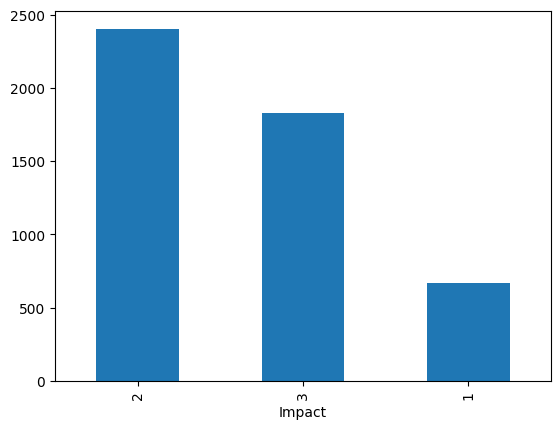

In [29]:
print(df['Impact'].value_counts())
df['Impact'].value_counts().plot(kind='bar')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/laptop/Documents/Magister/Memoria/git/imgs/impact_distribution.png'

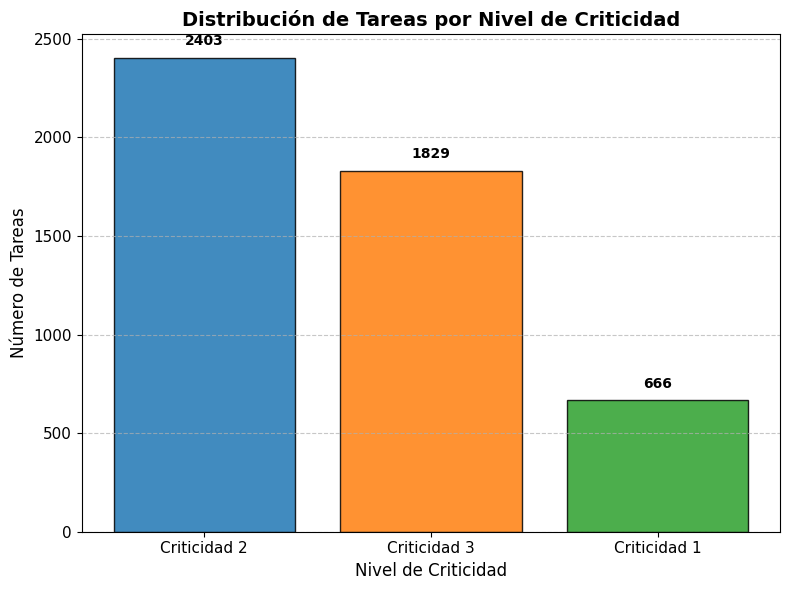

In [30]:
import matplotlib.pyplot as plt

# Datos para el gráfico (simulado según la información proporcionada)
impact_counts = {'Criticidad 2': 2403, 'Criticidad 3': 1829, 'Criticidad 1': 666}

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))  # Tamaño del gráfico
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Colores personalizados
plt.bar(impact_counts.keys(), impact_counts.values(), color=colors, edgecolor='black', alpha=0.85)

# Títulos y etiquetas
plt.title('Distribución de Tareas por Nivel de Criticidad', fontsize=14, fontweight='bold')
plt.xlabel('Nivel de Criticidad', fontsize=12)
plt.ylabel('Número de Tareas', fontsize=12)

# Líneas de cuadrícula solo en el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de valores en las barras
for i, val in enumerate(impact_counts.values()):
    plt.text(i, val + 50, str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Estilizar el gráfico
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Guardar el gráfico como una imagen de alta calidad para incluirlo en el documento LaTeX
plt.savefig('imgs/impact_distribution.png', dpi=300)
plt.show()


In [58]:
import altair as alt
import pandas as pd

# Datos para el gráfico
data = pd.DataFrame({
    'Nivel de Criticidad': ['1', '2', '3'],
    'Número de Tareas': [666, 2403, 1829]
})

# Color personalizado (de la tercera barra)
custom_color = '#d4605b'

# Crear el gráfico de barras
bars = (
    alt.Chart(data)
    .mark_bar(color=custom_color, width=40, cornerRadiusTopLeft=3, cornerRadiusTopRight=3)
    .encode(
        x=alt.X(
            'Nivel de Criticidad:N',  # Definir como nominal (N) para mantener el orden deseado
            sort=['1', '2', '3'],    # Orden de menor a mayor
            title='Nivel de Criticidad'
        ),
        y=alt.Y('Número de Tareas', title='Número de Tareas'),
        tooltip=['Nivel de Criticidad', 'Número de Tareas']
    )
)

# Agregar etiquetas sobre las barras
text = (
    alt.Chart(data)
    .mark_text(dy=-5, fontSize=12, fontWeight='bold', color='black')
    .encode(
        x=alt.X('Nivel de Criticidad:N', sort=['1', '2', '3']),
        y=alt.Y('Número de Tareas'),
        text=alt.Text('Número de Tareas:Q')
    )
)

# Combinar barras y texto
chart = (
    (bars + text)
    .properties(
        title='Distribución de Tareas por Nivel de Criticidad',
        width=300,
        height=300
    )
    .configure_title(
        fontSize=16,
        font='Arial',
        anchor='start',
        color='black',
        offset=20  # Espacio entre el título y el gráfico
    )
    .configure_axis(
        labelFontSize=12, titleFontSize=14, labelAngle=0  # Eje X horizontal
    )
)

# Mostrar el gráfico
chart


alt.LayerChart(...)

In [62]:
import altair as alt
import pandas as pd

# Datos para el gráfico
data = pd.DataFrame({
    'Configuración': ['a', 'b', 'c', 'd'],
    'Tareas Programadas': [0, 4854, 4658, 4831],
    'Makespan': [0, 1072, 492.75, 516.25],
    'Tiempo de Solución (s)': [3.43, 4.35, 8.42, 9.95]
})

# Crear el gráfico de burbujas
chart = (
    alt.Chart(data)
    .mark_circle()
    .encode(
        x=alt.X(
            'Tiempo de Solución (s):Q', 
            title='Tiempo de Solución (s)', 
            axis=alt.Axis(tickCount=5)
        ),
        y=alt.Y(
            'Makespan:Q', 
            title='Makespan', 
            axis=alt.Axis(tickCount=5)
        ),
        size=alt.Size(
            'Tareas Programadas:Q', 
            title='Tareas Programadas', 
            scale=alt.Scale(range=[100, 1000])
        ),
        color=alt.Color(
            'Configuración:N', 
            scale=alt.Scale(scheme='tableau10'), 
            title='Configuración'
        ),
        tooltip=['Configuración', 'Tareas Programadas', 'Makespan', 'Tiempo de Solución (s)']
    )
    .properties(
        title='Relación entre Tiempo de Solución, Makespan y Tareas Programadas',
        width=300,
        height=300
    )
)

# Agregar etiquetas para las configuraciones
text = (
    alt.Chart(data)
    .mark_text(align='center', dy=-10, fontSize=12, fontWeight='bold', color='black')
    .encode(
        x=alt.X('Tiempo de Solución (s):Q'),
        y=alt.Y('Makespan:Q'),
        text='Configuración'
    )
)

# Combinar gráfico y etiquetas
final_chart = (chart + text).configure_title(
    fontSize=16,
    font='Arial',
    anchor='start',
    color='black',
    offset=20  # Espacio entre el título y el gráfico
)

# Exportar gráfico si es necesario
# from altair_saver import save
# save(final_chart, "imgs/alpha_beta_bubble_analysis_with_offset_fixed.png")

# Mostrar el gráfico
final_chart


alt.LayerChart(...)